In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

# Data

In [3]:
# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)

train1 = utils.TextBeers()


# Pre-processing: transform everything to a-z and whitespace.


N = 11314 documents, C = 20 classes
3 4
N = 40000 documents, C = 4 classes


In [4]:
print(train.documents[0])
print(train1.documents[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Dark red color, light beige foam, average.	In the smell malt and caramel, not really light.	Again malt and caramel in the taste, not bad in the end.	Maybe a note of honey in teh back, and a light fruitiness.	Average body.	In the aftertaste a light bitterness, with the malt and red fruit.	Nothing exceptional, but not bad, drinkable beer.


In [5]:
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])

document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00 "functionality" (23084)
  1.00 "hav

In [6]:
print(train1.show_document(1)[:400])
train1.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train1.vectorize(stop_words='english')
print(train1.show_document(1)[:400])

document 1: label 1 --> 3, 69 words
Almost totally black. Beige foam, quite compact, not bad.	Light smell, just a bit of roast, and some hop. A bit too light.	The taste is light oo, and drinkable, with some malt, roast, hints of coffee.	Nothing exceptional, but after all drinkable and pleasant.	Light to average body.	In the aftertaste some dust, somr roast, hint of caramel, and a bit of bitterness.	No defect, drinkable, not bad.
document 1: label 1 --> 3, 69 words
  1.00 "aftertaste" (630)
  1.00 "average" (2345)
  2.00 "bad" (2522)
  1.00 "beige" (3244)
  3.00 "bit" (3682)
  1.00 "bitterness" (3730)
  1.00 "black" (3783)
  1.00 "body" (4125)
  1.00 "caramel" (5700)
  1.00 "coffee" (7362)
  1.00 "compact" (7631)
  1.00 "defect" (9596)
  3.00 "drinkable" (11300)
  1.00 "dust" (11560)
  1.00 "exceptional" (12833)
  1.00 "foam" (14257)
  1.00 "hint" (17129)
  1.00 "hints" (17135)
  1.00 "hop" (17363)
  1.00 "just" (19571)
  4.00 "light" (20721)
  1.00 "malt" (21662)
  1.00 "oo" (24916)
  

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

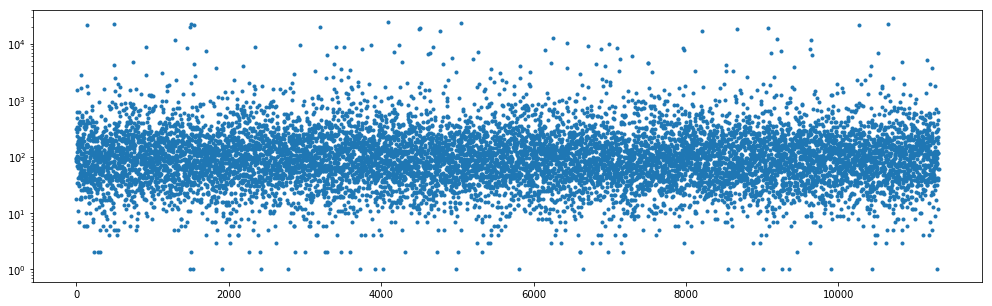

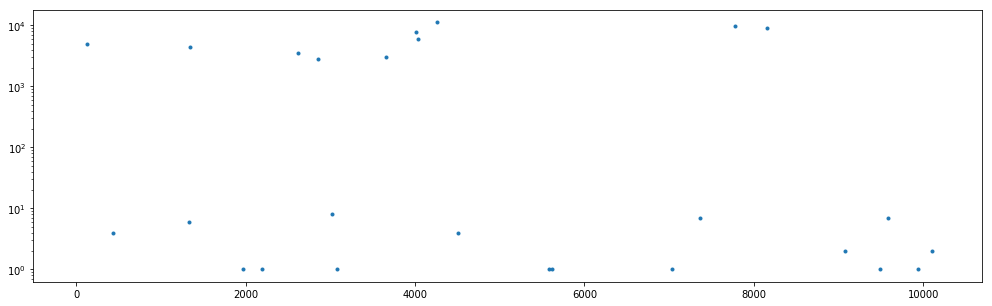

In [7]:
# Remove short documents.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');
# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [8]:
from collections import Counter
train1.data_info(True)
Counter(train1.labels)

N = 40000 documents, M = 40453 words, sparsity=0.1426%
   2139 documents in class  0 (2)
  10401 documents in class  1 (3)
  24463 documents in class  2 (4)
   2997 documents in class  3 (5)


Counter({0: 2139, 1: 10401, 2: 24463, 3: 2997})

N = 40000 documents, M = 40453 words, sparsity=0.1426%
   2139 documents in class  0 (2)
  10401 documents in class  1 (3)
  24463 documents in class  2 (4)
   2997 documents in class  3 (5)
N = 39977 documents, M = 40453 words, sparsity=0.1426%
shortest: 0, longest: 914 words


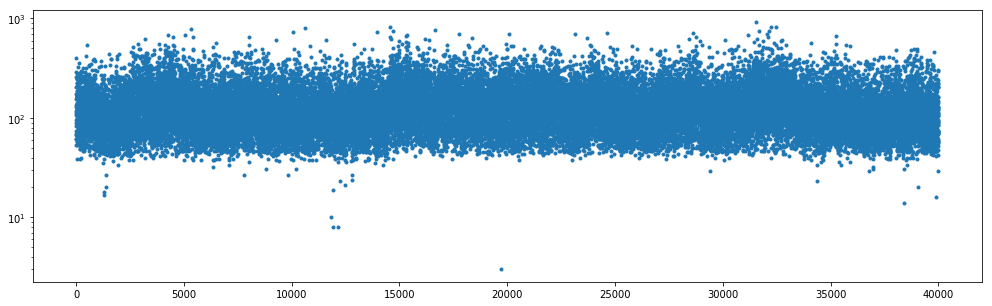

In [9]:
# Remove short documents.
train1.data_info(True)
wc1 = train1.remove_short_documents(nwords=20, vocab='full')
train1.data_info()
print('shortest: {}, longest: {} words'.format(wc1.min(), wc1.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc1, '.');


N = 39977 documents, M = 40453 words, sparsity=0.1426%


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


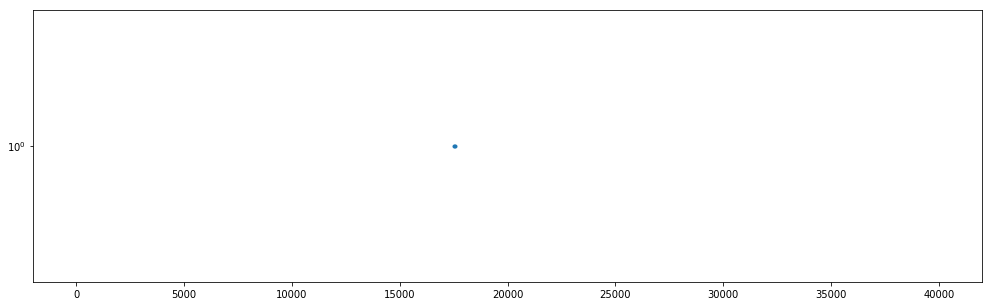

In [10]:

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train1.vocab.index('ax')
    wc1 = train1.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc1 < freq).squeeze()
    dataset.keep_documents(idx)
    return wc1
wc1 = remove_encoded_images(train1)
train1.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc1, '.');

In [11]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()
# Further feature selection. (TODO)

53279 words not found in corpus
N = 10171 documents, M = 19328 words, sparsity=0.3141%


In [12]:
# Word embedding
if True:
    train1.embed()
else:
    train1.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train1.data_info()
# Further feature selection. (TODO)

27872 words not found in corpus
N = 39977 documents, M = 12581 words, sparsity=0.4500%


most frequent words
    0: num        163934 counts
    1: dollar      10562 counts
    2: people       4093 counts
    3: like         3942 counts
    4: don          3869 counts
    5: just         3721 counts
    6: know         3464 counts
    7: use          3166 counts
    8: think        2995 counts
    9: time         2966 counts
   10: does         2749 counts
   11: new          2606 counts
   12: good         2492 counts
   13: edu          2416 counts
   14: way          2032 counts
   15: make         2022 counts
   16: god          1976 counts
   17: used         1874 counts
   18: ve           1857 counts
   19: say          1841 counts
N = 10171 documents, M = 1000 words, sparsity=2.8353%
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  3.00 "num" (0)
  1.00 "number" (40)
  1.00 "thanks" (48)
  1.00 "day" (76)
  1.00 "send" (97)
  1.00 "disk" (157)
  1.00 "message" (206)
  2.00 "speed" (226)
  1.00 "days" (244)
  1.00 "especially" (383)
  2.00 "add" (443)
  1.0

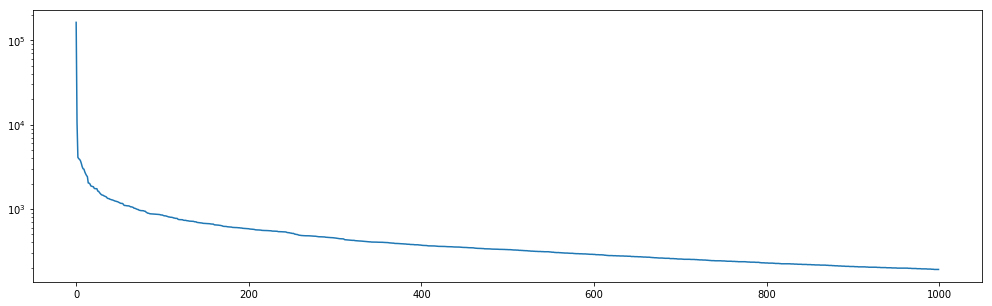

In [13]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(1000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

most frequent words
    0: beer        50177 counts
    1: num         49809 counts
    2: head        39265 counts
    3: taste       28368 counts
    4: nice        26489 counts
    5: like        25112 counts
    6: good        24614 counts
    7: malt        23449 counts
    8: dark        23420 counts
    9: sweet       22734 counts
   10: hops        22575 counts
   11: light       21245 counts
   12: chocolate   20939 counts
   13: coffee      20371 counts
   14: flavor      19066 counts
   15: bit         18974 counts
   16: carbonation  18231 counts
   17: aroma       16723 counts
   18: little      16718 counts
   19: glass       16384 counts
N = 39977 documents, M = 1000 words, sparsity=4.5756%
document 1: label 1 --> 3, 69 words
  1.00 "taste" (3)
  1.00 "malt" (7)
  4.00 "light" (11)
  1.00 "coffee" (13)
  3.00 "bit" (15)
  1.00 "smell" (20)
  1.00 "just" (22)
  1.00 "hop" (29)
  1.00 "caramel" (32)
  1.00 "body" (34)
  1.00 "black" (36)
  1.00 "bitterness" (39)
  1.00 "qu

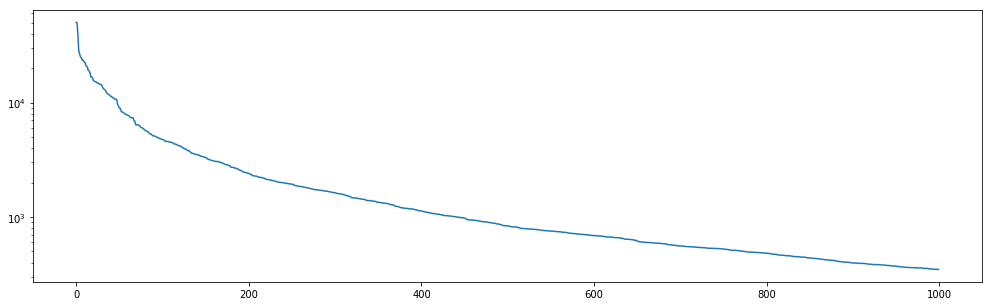

In [14]:
# Feature selection.
# Other options include: mutual information or document count.
freq1 = train1.keep_top_words(1000, 20)
train1.data_info()
train1.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq1);

# Remove documents whose signal would be the zero vector.
wc1 = train1.remove_short_documents(nwords=5, vocab='selected')
train1.data_info(True)

In [15]:
train.normalize(norm='l1')
train.show_document(1);

document 1: label 4 --> comp.sys.mac.hardware, 92 words
  0.13 "num" (0)
  0.04 "number" (40)
  0.04 "thanks" (48)
  0.04 "day" (76)
  0.04 "send" (97)
  0.04 "disk" (157)
  0.04 "message" (206)
  0.09 "speed" (226)
  0.04 "days" (244)
  0.04 "especially" (383)
  0.09 "add" (443)
  0.04 "haven" (467)
  0.04 "network" (529)
  0.04 "cards" (591)
  0.04 "knowledge" (614)
  0.04 "base" (708)
  0.04 "floppy" (758)
  0.09 "clock" (977)


In [16]:
train1.normalize(norm='l1')
train1.show_document(1);

document 1: label 1 --> 3, 69 words
  0.03 "taste" (3)
  0.03 "malt" (7)
  0.11 "light" (11)
  0.03 "coffee" (13)
  0.09 "bit" (15)
  0.03 "smell" (20)
  0.03 "just" (22)
  0.03 "hop" (29)
  0.03 "caramel" (32)
  0.03 "body" (34)
  0.03 "black" (36)
  0.03 "bitterness" (39)
  0.03 "quite" (52)
  0.09 "drinkable" (75)
  0.03 "hint" (78)
  0.03 "hints" (108)
  0.03 "aftertaste" (112)
  0.06 "bad" (132)
  0.03 "foam" (156)
  0.03 "pleasant" (195)
  0.03 "average" (198)
  0.09 "roast" (232)
  0.03 "beige" (498)
  0.03 "exceptional" (674)
  0.03 "totally" (815)


In [17]:
# Test dataset.
test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)

#test = utils.TextBeers(test=True)

test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

N = 7532 documents, C = 20 classes
N = 7532 documents, M = 1000 words, sparsity=2.4662%
shortest: 0, longest: 23751 words
N = 6695 documents, M = 1000 words, sparsity=2.7528%
    275 documents in class  0 (alt.atheism)
    355 documents in class  1 (comp.graphics)
    358 documents in class  2 (comp.os.ms-windows.misc)
    370 documents in class  3 (comp.sys.ibm.pc.hardware)
    348 documents in class  4 (comp.sys.mac.hardware)
    365 documents in class  5 (comp.windows.x)
    359 documents in class  6 (misc.forsale)
    336 documents in class  7 (rec.autos)
    321 documents in class  8 (rec.motorcycles)
    345 documents in class  9 (rec.sport.baseball)
    350 documents in class 10 (rec.sport.hockey)
    344 documents in class 11 (sci.crypt)
    362 documents in class 12 (sci.electronics)
    345 documents in class 13 (sci.med)
    346 documents in class 14 (sci.space)
    365 documents in class 15 (soc.religion.christian)
    319 documents in class 16 (talk.politics.guns)
    338 

In [18]:
# Test dataset.
#test1 = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)

test1 = utils.TextBeers(test=True)

test1.clean_text(num='substitute')
test1.vectorize(vocabulary=train1.vocab)
test1.data_info()
wc1 = test1.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc1.min(), wc1.max()))
test1.data_info(True)
test1.normalize(norm='l1')

3 4
N = 9411 documents, C = 4 classes
N = 9411 documents, M = 1000 words, sparsity=4.1138%
shortest: 0, longest: 300 words
N = 9405 documents, M = 1000 words, sparsity=4.1163%
    507 documents in class  0 (2)
   2749 documents in class  1 (3)
   5629 documents in class  2 (4)
    520 documents in class  3 (5)


In [19]:
train1.data_info(True)



N = 39977 documents, M = 1000 words, sparsity=4.5756%
   2139 documents in class  0 (2)
  10397 documents in class  1 (3)
  24450 documents in class  2 (4)
   2991 documents in class  3 (5)


In [20]:
from collections import Counter
Counter(test1.labels)

Counter({0: 507, 1: 2749, 2: 5629, 3: 520})

In [21]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

#del train, test

In [22]:
if True:
    train_data1 = train1.data.astype(np.float32)
    test_data1 = test1.data.astype(np.float32)
    train_labels1 = train1.labels
    test_labels1 = test1.labels
else:
    perm1 = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    print("bau")
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data1 = train1.embeddings.astype(np.float32)
else:
    graph_data1 = train1.data.T.astype(np.float32).toarray()

#del train, test

In [23]:
train1.embeddings.shape

(1000, 100)

# Feature graph

In [ ]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

In [24]:
t_start = time.process_time()
dist, idx = graph.distance_lshforest(graph_data.astype(np.float64), k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist.astype(np.float32), idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

11551 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11551 edges
Execution time: 2.20s


In [ ]:
A.todense()

In [25]:
t_start = time.process_time()
dist1, idx1 = graph.distance_lshforest(graph_data1.astype(np.float64), k=FLAGS.number_edges, metric=FLAGS.metric)
A1 = graph.adjacency(dist.astype(np.float32), idx1)
print("{} > {} edges".format(A1.nnz//2, FLAGS.number_edges*graph_data1.shape[0]//2))
A1 = graph.replace_random_edges(A1, 0)
graphs1, perm1 = coarsening.coarsen(A1, levels=FLAGS.coarsening_levels, self_connections=False)
L1 = [graph.laplacian(A1, normalized=True) for A1 in graphs1]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

11212 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11212 edges
Execution time: 2.39s


In [ ]:
graph_data1.shape

In [ ]:
A1.todense()

In [26]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Execution time: 0.22s


In [27]:
t_start = time.process_time()
train_data1 = scipy.sparse.csr_matrix(coarsening.perm_data(train_data1.toarray(), perm1))
test_data1 = scipy.sparse.csr_matrix(coarsening.perm_data(test_data1.toarray(), perm1))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm1

Execution time: 0.65s


# Classification

**Reminder**: change the optimizer to Adam in `lib/models.py`.

In [28]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [29]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data1 = train_data1[:FLAGS.val_size,:]
    val_labels1 = train_labels1[:FLAGS.val_size]
    train_data1 = train_data1[FLAGS.val_size:,:]
    train_labels1 = train_labels1[FLAGS.val_size:]
else:
    val_data1 = test_data1
    val_labels1 = test_labels1

In [30]:
if True:
    utils.baseline(train_data, train_labels, test_data, test_labels)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy:      46.08 55.27 64.24 99.13 71.39 69.75 73.51
Test accuracy:       28.95 46.90 48.99 49.26 54.80 56.39 57.15
Train F1 (weighted): 46.34 53.35 64.96 99.13 69.93 68.96 72.86
Test F1 (weighted):  28.54 44.72 49.45 48.62 52.50 55.03 56.03
Execution time:       6.90  0.95  0.02  1.75  0.02  1.02  0.92


In [31]:
if True:
    utils.baseline(train_data1, train_labels1, test_data1, test_labels1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy:      66.23 64.10 51.74 98.53 61.16 66.43 67.34
Test accuracy:       58.48 62.45 44.56 58.39 59.85 63.76 64.13
Train F1 (weighted): 60.24 54.26 54.13 98.51 46.42 58.82 60.58
Test F1 (weighted):  51.43 53.53 46.39 55.16 44.82 57.52 58.63
Execution time:      212.39  1.40  0.08 15.62  0.06  2.13  1.77


In [32]:
common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [33]:
common = {}
common['dir_name']       = 'beer/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels1) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C1 = max(train_labels1) + 1  # number of classes

model_perf1 = utils.model_perf()

In [ ]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    #model_perf1.test(models.cgcnn(L, **params), name, params,
    #                train_data1, train_labels1, val_data1, val_labels1, test_data1, test_labels1)

In [35]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C1]
    #model_perf.test(models.cgcnn(L, **params), name, params,
                    #train_data, train_labels, val_data, val_labels, test_data, test_labels)
    model_perf1.test(models.cgcnn(L, **params), name, params,
                    train_data1, train_labels1, val_data1, val_labels1, test_data1, test_labels1)

NN architecture
  input: M_0 = 1000
  layer 1: logits (softmax)
    representation: M_1 = 4
    weights: M_0 * M_1 = 1000 * 4 = 4000
    biases: M_1 = 4
step 400 / 31981 (epoch 1.00 / 80):
  learning_rate = 1.00e+03, loss_average = 3.19e+02
  validation accuracy: 59.67 (5612 / 9405), f1 (weighted): 45.34, loss: 2.52e+02
  time: 2s (wall 1s)
step 800 / 31981 (epoch 2.00 / 80):
  learning_rate = 9.50e+02, loss_average = 2.79e+02
  validation accuracy: 59.86 (5630 / 9405), f1 (weighted): 44.84, loss: 4.31e+02
  time: 3s (wall 2s)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 1200 / 31981 (epoch 3.00 / 80):
  learning_rate = 9.02e+02, loss_average = 1.71e+02
  validation accuracy: 61.70 (5803 / 9405), f1 (weighted): 58.94, loss: 5.48e+01
  time: 4s (wall 3s)
step 1600 / 31981 (epoch 4.00 / 80):
  learning_rate = 8.57e+02, loss_average = 1.21e+02
  validation accuracy: 60.50 (5690 / 9405), f1 (weighted): 46.66, loss: 1.56e+02
  time: 6s (wall 4s)
step 2000 / 31981 (epoch 5.00 / 80):
  learning_rate = 7.74e+02, loss_average = 1.16e+02
  validation accuracy: 59.32 (5579 / 9405), f1 (weighted): 58.71, loss: 5.78e+01
  time: 7s (wall 5s)
step 2400 / 31981 (epoch 6.00 / 80):
  learning_rate = 7.35e+02, loss_average = 1.88e+02
  validation accuracy: 54.75 (5149 / 9405), f1 (weighted): 49.79, loss: 1.55e+02
  time: 8s (wall 6s)
step 2800 / 31981 (epoch 7.00 / 80):
  learning_rate = 6.98e+02, loss_average = 1.48e+02
  validation accuracy: 59.89 (5633 / 9405), f1 (weighted): 48.08, loss: 1.46e+02
  time: 10s (wall 7s)
step 3200 / 31981 (epoch 8.00 / 80):
  learn

step 18400 / 31981 (epoch 46.03 / 80):
  learning_rate = 9.45e+01, loss_average = 7.87e+00
  validation accuracy: 56.18 (5284 / 9405), f1 (weighted): 57.09, loss: 1.28e+01
  time: 66s (wall 45s)
step 18800 / 31981 (epoch 47.03 / 80):
  learning_rate = 8.97e+01, loss_average = 8.47e+00
  validation accuracy: 61.70 (5803 / 9405), f1 (weighted): 55.28, loss: 1.61e+01
  time: 67s (wall 46s)
step 19200 / 31981 (epoch 48.03 / 80):
  learning_rate = 8.53e+01, loss_average = 1.16e+01
  validation accuracy: 59.04 (5553 / 9405), f1 (weighted): 55.22, loss: 1.44e+01
  time: 69s (wall 47s)
step 19600 / 31981 (epoch 49.03 / 80):
  learning_rate = 8.10e+01, loss_average = 9.67e+00
  validation accuracy: 62.31 (5860 / 9405), f1 (weighted): 59.56, loss: 1.29e+01
  time: 70s (wall 48s)
step 20000 / 31981 (epoch 50.03 / 80):
  learning_rate = 7.69e+01, loss_average = 8.18e+00
  validation accuracy: 55.65 (5234 / 9405), f1 (weighted): 56.15, loss: 1.28e+01
  time: 72s (wall 49s)
step 20400 / 31981 (epoch

In [ ]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'fourier'
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.001
    params['decay_rate']     = 1
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [L[0].shape[0]]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'spline'
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C1]
    model_perf1.test(models.cgcnn(L, **params), name, params,
                    train_data1, train_labels1, val_data1, val_labels1, test_data1, test_labels1)

In [ ]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C1]
    model_perf1.test(models.cgcnn(L, **params), name, params,
                    train_data1, train_labels1, val_data1, val_labels1, test_data1, test_labels1)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 4
    weights: M_2 * M_3 = 100 * 4 = 400
    biases: M_3 = 4
step 400 / 31981 (epoch 1.00 / 80):
  learning_rate = 1.00e-01, loss_average = 1.02e+00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 59.85 (5629 / 9405), f1 (weighted): 44.82, loss: 1.02e+00
  time: 123s (wall 29s)
step 800 / 31981 (epoch 2.00 / 80):
  learning_rate = 9.99e-02, loss_average = 9.29e-01
  validation accuracy: 60.94 (5731 / 9405), f1 (weighted): 50.86, loss: 9.69e-01
  time: 238s (wall 54s)
step 1200 / 31981 (epoch 3.00 / 80):
  learning_rate = 9.98e-02, loss_average = 8.37e-01
  validation accuracy: 62.55 (5883 / 9405), f1 (weighted): 58.42, loss: 9.18e-01
  time: 353s (wall 80s)
step 1600 / 31981 (epoch 4.00 / 80):
  learning_rate = 9.97e-02, loss_average = 7.73e-01
  validation accuracy: 64.25 (6043 / 9405), f1 (weighted): 59.81, loss: 8.93e-01
  time: 457s (wall 103s)
step 2000 / 31981 (epoch 5.00 / 80):
  learning_rate = 9.95e-02, loss_average = 7.86e-01
  validation accuracy: 63.58 (5980 / 9405), f1 (weighted): 60.97, loss: 8.85e-01
  time: 562s (wall 126s)
step 2400 / 31981 (epoch 6.00 / 80):
  learning_rate = 9.94e-02, loss_average = 7.52e-01
  validation accuracy: 64.44 

In [ ]:
model_perf.show()

In [ ]:
model_perf1.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))